# Part load modeling in TESPy

## Introduction

- why partload modeling -> ambient temperature vs. compressor power (pressure ratio/mass flow)
- how does the partload model work in TESPy?
- table/figures with part load modeling assumptions (operational boundaries, characteristic functions)

## Preparing the model

In [135]:
from tespy.components import Condenser, HeatExchanger, CycleCloser, Compressor, Valve, Source, Sink
from tespy.connections import Connection, Ref
from tespy.networks import Network

wf = "R290"
nwk = Network(fluids=[wf, "air", "Water"], p_unit="bar", T_unit="C", iterinfo=False)

cp = Compressor("compressor")
ev = HeatExchanger("evaporator")
cd = Condenser("condenser")
va = Valve("expansion valve")
cc = CycleCloser("cycle closer")

so1 = Source("ambient air source")
si1 = Sink("ambient air sink")
so2 = Source("heating source")
si2 = Sink("heating sink")

c0 = Connection(va, "out1", cc, "in1", label="0")
c1 = Connection(cc, "out1", ev, "in2", label="1")
c2 = Connection(ev, "out2", cp, "in1", label="2")
c3 = Connection(cp, "out1", cd, "in1", label="3")
c4 = Connection(cd, "out1", va, "in1", label="4")

nwk.add_conns(c0, c1, c2, c3, c4)

c11 = Connection(so1, "out1", ev, "in1", label="11")
c12 = Connection(ev, "out1", si1, "in1", label="12")

c21 = Connection(so2, "out1", cd, "in2", label="21")
c22 = Connection(cd, "out2", si2, "in1", label="22")

nwk.add_conns(c11, c12, c21, c22)

# connections
# c2.set_attr(T=-5)
c4.set_attr(T=55)

# components
Q_design = -10e3
cp.set_attr(eta_s=0.8)
cd.set_attr(Q=Q_design)

# connections
c2.set_attr(fluid={wf: 1, "Water": 0, "air": 0}, x=1.0)
c11.set_attr(fluid={wf: 0, "Water": 0, "air": 1}, p=1.0, T=5)
c12.set_attr(T=Ref(c11, 1, -2))
c21.set_attr(fluid={wf: 0, "Water": 1, "air": 0}, p=3.0, T=40)
c22.set_attr(T=50)

# components
cd.set_attr(pr1=1, pr2=1)
ev.set_attr(pr1=1, pr2=1, ttd_l=5)

nwk.solve("design")

cd.set_attr(ttd_u=5)
c4.set_attr(T=None)

nwk.solve("design")

nwk.print_results(colored=False)
nwk.save("design-state")
nwk.save("tmp")

##### RESULTS (Valve) #####
+-----------------+----------+----------+
|                 |       pr |     zeta |
|-----------------+----------+----------|
| expansion valve | 2.34e-01 | 7.30e+10 |
+-----------------+----------+----------+
##### RESULTS (HeatExchanger) #####
+------------+-----------+----------+----------+----------+----------+----------+----------+----------+----------+
|            |         Q |       kA |   td_log |    ttd_u |    ttd_l |      pr1 |      pr2 |    zeta1 |    zeta2 |
|------------+-----------+----------+----------+----------+----------+----------+----------+----------+----------|
| evaporator | -7.22e+03 | 1.21e+03 | 5.94e+00 | 7.00e+00 | 5.00e+00 | 1.00e+00 | 1.00e+00 | 0.00e+00 | 1.83e-06 |
+------------+-----------+----------+----------+----------+----------+----------+----------+----------+----------+
##### RESULTS (CycleCloser) #####
+--------------+------------------+-------------------+
|              |   mass_deviation |   fluid_deviation |
|----

In [136]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt


temperature_range = np.linspace(-10, 30, 41)
results_temperature = pd.DataFrame(
    index=temperature_range,
    columns=["compressor-power", "pressure-ratio", "COP"]
)

for temperature in temperature_range:

    c11.set_attr(T=temperature)
    nwk.solve("design")

    results_temperature.loc[temperature, "compressor-power"] = cp.P.val
    results_temperature.loc[temperature, "pressure-ratio"] = cp.pr.val
    results_temperature.loc[temperature, "COP"] = abs(cd.Q.val) / cp.P.val

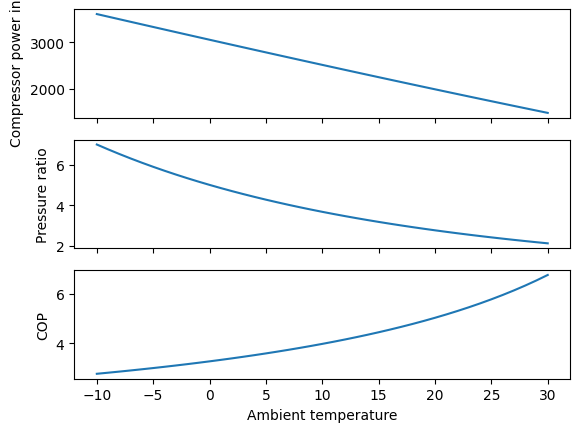

In [137]:
fig, ax = plt.subplots(3, sharex=True)

ax[0].plot(temperature_range, results_temperature["compressor-power"])
ax[1].plot(temperature_range, results_temperature["pressure-ratio"])
ax[2].plot(temperature_range, results_temperature["COP"])

ax[0].set_ylabel("Compressor power in W")
ax[1].set_ylabel("Pressure ratio")
ax[2].set_ylabel("COP")
_ = ax[2].set_xlabel("Ambient temperature")


In [138]:
heat_range = np.linspace(0.5, 1.1, 13) * Q_design
results_heat = pd.DataFrame(
    index=heat_range,
    columns=["compressor-power", "pressure-ratio", "COP"]
)
T_heat_partload = 5
c11.set_attr(T=T_heat_partload)

for heat in heat_range[::-1]:
    cd.set_attr(Q=heat)
    nwk.solve("design")

    results_heat.loc[heat, "compressor-power"] = cp.P.val
    results_heat.loc[heat, "pressure-ratio"] = cp.pr.val
    results_heat.loc[heat, "COP"] = abs(cd.Q.val) / cp.P.val

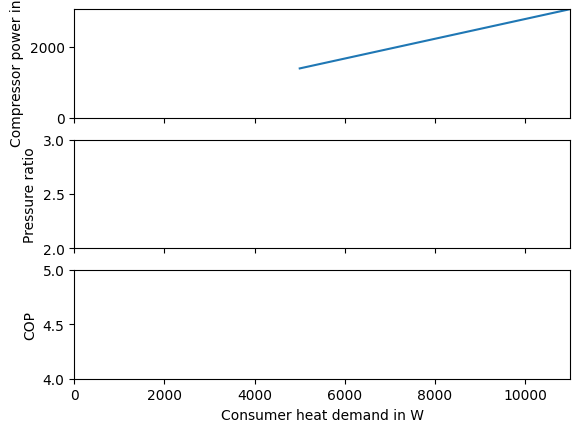

In [139]:
fig, ax = plt.subplots(3, sharex=True)

ax[0].plot(np.abs(heat_range), results_heat["compressor-power"])
ax[1].plot(np.abs(heat_range), results_heat["pressure-ratio"])
ax[2].plot(np.abs(heat_range), results_heat["COP"])

ax[0].set_ylabel("Compressor power in W")
ax[0].set_ylim([0, results_heat["compressor-power"].max()])
ax[1].set_ylabel("Pressure ratio")
ax[1].set_ylim([2, 3])
ax[2].set_ylabel("COP")
ax[2].set_ylim([4, 5])
ax[2].set_xlim([0, np.abs(heat_range).max()])
_ = ax[2].set_xlabel("Consumer heat demand in W")

In [140]:
cd.set_attr(Q=Q_design)
cp.set_attr(design=["eta_s"], offdesign=["eta_s_char"])
cp.eta_s_char.char_func.extrapolate = True
ev.set_attr(design=["ttd_l"], offdesign=["kA_char"])
cd.set_attr(design=["ttd_u"], offdesign=["kA_char"])
c11.set_attr(offdesign=["m"])
c12.set_attr(design=["T"])

# temperature_range = np.linspace(5, -10, 16)

results_temperature_partload = pd.DataFrame(
    index=temperature_range,
    columns=["compressor-power", "pressure-ratio", "COP"]
)


for temperature in temperature_range:

    c11.set_attr(T=temperature)
    nwk.solve("offdesign", design_path="design-state")

    results_temperature_partload.loc[temperature, "compressor-power"] = cp.P.val
    results_temperature_partload.loc[temperature, "pressure-ratio"] = cp.pr.val
    results_temperature_partload.loc[temperature, "COP"] = abs(cd.Q.val) / cp.P.val

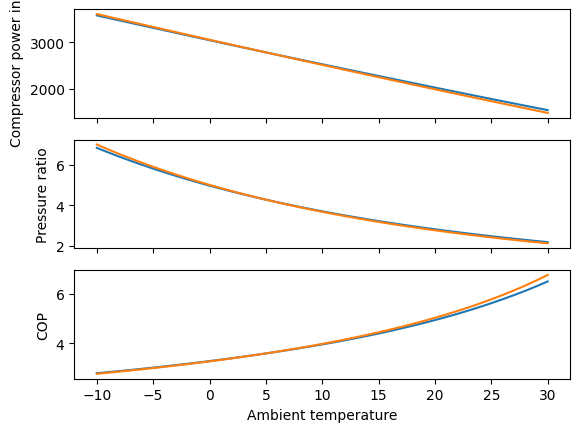

In [141]:
fig, ax = plt.subplots(3, sharex=True)

ax[0].plot(temperature_range, results_temperature_partload["compressor-power"])
ax[1].plot(temperature_range, results_temperature_partload["pressure-ratio"])
ax[2].plot(temperature_range, results_temperature_partload["COP"])

ax[0].plot(temperature_range, results_temperature["compressor-power"])
ax[1].plot(temperature_range, results_temperature["pressure-ratio"])
ax[2].plot(temperature_range, results_temperature["COP"])

ax[0].set_ylabel("Compressor power in W")
ax[1].set_ylabel("Pressure ratio")
ax[2].set_ylabel("COP")
_ = ax[2].set_xlabel("Ambient temperature")

```{note}
A way of controlling whether your setup for the part load modeling is correct is to check if offdesign parameter settings of the model lead to the same result as in the design parameter specifications. If these numbers do not align, there might be something wrong the model setup. In this case, we always have the design heat load and we have to compare the results at the design ambient temperature, i.e. 5°C.
```

In [ ]:
results_temperature.loc[5]

In [ ]:
results_temperature_partload.loc[5]

In [142]:
c11.set_attr(T=T_heat_partload)
results_heat_partload = pd.DataFrame(
    index=heat_range,
    columns=["compressor-power", "pressure-ratio", "COP"]
)

for heat in heat_range[::-1]:
    cd.set_attr(Q=heat)
    nwk.solve("offdesign", design_path="design-state")

    results_heat_partload.loc[heat, "compressor-power"] = cp.P.val
    results_heat_partload.loc[heat, "pressure-ratio"] = cp.pr.val
    results_heat_partload.loc[heat, "COP"] = abs(cd.Q.val) / cp.P.val

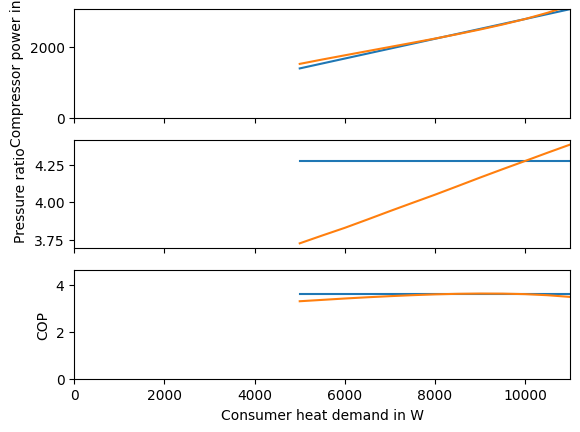

In [143]:
fig, ax = plt.subplots(3, sharex=True)

ax[0].plot(np.abs(heat_range), results_heat["compressor-power"], label="no partload")
ax[1].plot(np.abs(heat_range), results_heat["pressure-ratio"])
ax[2].plot(np.abs(heat_range), results_heat["COP"])
ax[0].plot(np.abs(heat_range), results_heat_partload["compressor-power"], label="partload")
ax[1].plot(np.abs(heat_range), results_heat_partload["pressure-ratio"])
ax[2].plot(np.abs(heat_range), results_heat_partload["COP"])

ax[0].set_ylabel("Compressor power in W")
ax[0].set_ylim([0, results_heat["compressor-power"].max()])
ax[1].set_ylabel("Pressure ratio")
ax[2].set_ylabel("COP")
ax[2].set_ylim([0, results_heat_partload["COP"].max() + 1])
ax[2].set_xlim([0, np.abs(heat_range).max()])
_ = ax[2].set_xlabel("Consumer heat demand in W")

We can have the same look at the results from the dataframes. Since we inspected the part load behaviour for the heat output at the design temperature level of the ambient, we should see equal values in the results for the design heat production, i.e. `-10,000.0` W.

In [144]:
results_heat_partload.loc[Q_design]

compressor-power    2781.865348
pressure-ratio         4.274894
COP                     3.59471
Name: -10000.0, dtype: object

In [145]:
results_heat.loc[Q_design]

compressor-power    2781.865348
pressure-ratio         4.274894
COP                     3.59471
Name: -10000.0, dtype: object

In [146]:
temperature_range = [-10, -5, 0, 5, 10, 15, 20]

results = {}


for temperature in temperature_range:
    results[temperature] = pd.DataFrame(index=heat_range, columns=["COP", "compressor-power", "T-evaporation", "T-condensation"])
    c11.set_attr(T=temperature)
    for heat in heat_range[::-1]:
        cd.set_attr(Q=heat)
        if heat == heat_range[-1]:
            nwk.solve("offdesign", design_path="design-state", init_path="tmp")
            nwk.save("tmp")
        else:
            nwk.solve("offdesign", design_path="design-state")  

        results[temperature].loc[heat, "COP"] = abs(cd.Q.val) / cp.P.val
        results[temperature].loc[heat, "compressor-power"] = cp.P.val
        results[temperature].loc[heat, "T-evaporation"] = c2.T.val
        results[temperature].loc[heat, "T-condensation"] = c4.T.val

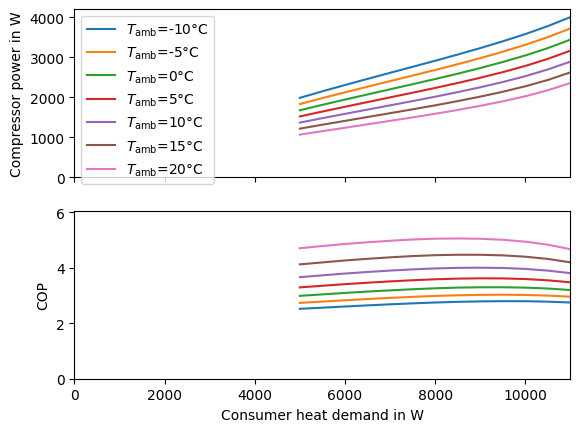

In [147]:
power_max = 0
COP_max = 0

fig, ax = plt.subplots(2, sharex=True)

for temp in temperature_range:

    ax[0].plot(np.abs(results[temp].index), results[temp]["compressor-power"], label="$T_\\mathrm{amb}$=" + str(temp) + "°C")
    ax[1].plot(np.abs(results[temp].index), results[temp]["COP"])
    COP_max = max(results[temp]["COP"].max(), COP_max)
    power_max = max(results[temp]["compressor-power"].max(), power_max)

ax[0].legend()
ax[0].set_ylabel("Compressor power in W")
ax[0].set_ylim([0, power_max * 1.05])
ax[1].set_ylabel("COP")
ax[1].set_ylim([0, COP_max + 1])
ax[1].set_xlim([0, np.abs(heat_range).max()])
_ = ax[1].set_xlabel("Consumer heat demand in W")

In [148]:
def least_squares(x, y):
    A = np.vstack([x, np.ones(len(x))]).T
    slope, offset = np.linalg.lstsq(A, y, rcond=None)[0]
    return slope, offset

,COP,compressor-power,T-evaporation,T-condensation
-5000.0,3.292855,1518.439296,0.807296,52.570864
-5500.0,3.350747,1641.425074,0.51537,52.809447
-6000.0,3.409243,1759.921324,0.230896,53.034283
-6500.0,3.461852,1877.607613,-0.05918,53.291475
-7000.0,3.508829,1994.967509,-0.355931,53.54155
-7500.0,3.550774,2112.215425,-0.644847,53.778156
-8000.0,3.58551,2231.202767,-0.925343,54.010711
-8500.0,3.60884,2355.327289,-1.204524,54.263904
-9000.0,3.619917,2486.244707,-1.483012,54.51417
-9500.0,3.616149,2627.104321,-1.748951,54.756435


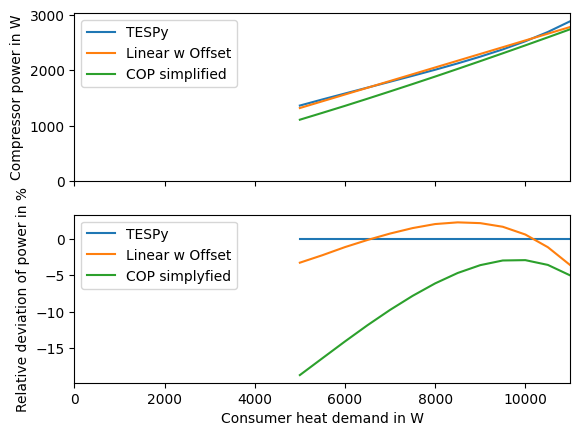

In [149]:
temp = 10

COP_c_simple = (273.15 + 58) / (58 - -10)
eta_c_simple = 0.65

x = -results[temp].index.values.astype(float)
y = results[temp]["compressor-power"].values.astype(float)
yy_tespy = y


COP_c_simple = (results[temp]["T-condensation"] + 273.15) / (results[temp]["T-condensation"] - results[temp]["T-evaporation"])
eta_c_simple = 0.649

# m, c = constrained_polynomial_regression(x, y, 0, 2)
# yy_linear = c + m * x

fig, ax = plt.subplots(2, sharex=True)

ax[0].plot(x, yy_tespy, label="TESPy")
# ax[0].plot(x, yy_linear, label="Linear wo Offset")

slope, offset = least_squares(x, y)
yy_offset = offset + slope * x
ax[0].plot(x, yy_offset, label="Linear w Offset")
ax[0].plot(x, x / (COP_c_simple * eta_c_simple), label="COP simplified")

ax[1].plot(x, (yy_tespy - yy_tespy) / yy_tespy * 100, label="TESPy")
# ax[1].plot(x, (yy_linear - yy_tespy) / yy_tespy * 100, label="Linear wo Offset")
ax[1].plot(x, (yy_offset - yy_tespy) / yy_tespy * 100, label="Linear w Offset")
ax[1].plot(x, (x / (COP_c_simple * eta_c_simple) - yy_tespy) / yy_tespy * 100, label="COP simplyfied")

ax[0].legend()
ax[1].legend()
ax[0].set_ylabel("Compressor power in W")
ax[0].set_ylim([0, y.max() * 1.05])
ax[1].set_ylabel("Relative deviation of power in %")
ax[1].set_xlim([0, x.max()])
_ = ax[1].set_xlabel("Consumer heat demand in W")

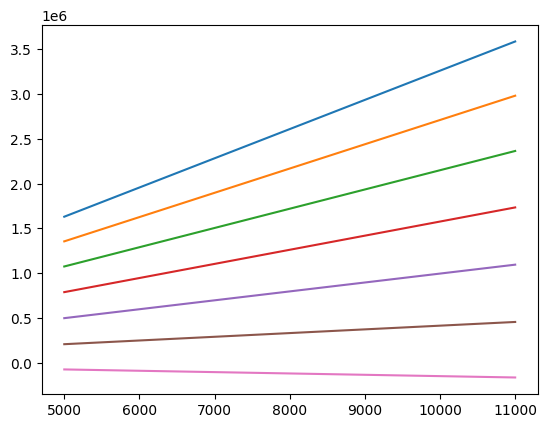

In [150]:
for temp in temperature_range:
        
    x = -results[temp].index.values.astype(float)
    y = results[temp]["compressor-power"].values.astype(float)
    slope, offset = least_squares(x, y)
    plt.plot(x, slope * x + offset)

## Prepare output for solph

For the `OffsetTransformer` we need a slightly different output structure, than provided by the results dictionary with the pandas dataframes for every temperature: The coefficients (offset and slope) for every ambient temperature level are required. We can build a new dataframe, that holds these information and export them into csv format and export those information.

In [151]:
export_df = pd.DataFrame(index=temperature_range, columns=["slope", "offset"])

for key, data in results.items():
    x = -data.index.values.astype(float)
    y = data["compressor-power"].values.astype(float)
    export_df.loc[key] = least_squares(x, y)

export_df.to_csv("coefficients-offset-transformer.csv")